	
Scene Understanding Datasets
stanford background dataset (14.0MB) [.tar.gz]
The Stanford Background Dataset is a new dataset introduced in Gould et al. (ICCV 2009) for evaluating methods for geometric and semantic scene understanding. The dataset contains 715 images chosen from existing public datasets: LabelMe, MSRC, PASCAL VOC and Geometric Context. Our selection criteria were for the images to be of outdoor scenes, have approximately 320-by-240 pixels, contain at least one foreground object, and have the horizon position within the image (it need not be visible).
Semantic and geometric labels were obtained using Amazon's Mechanical Turk (AMT). The labels are:

horizons.txt	image dimensions and location of horizon
labels/*.regions.txt	integer matrix indicating each pixel's semantic class (sky, tree, road, grass, water, building, mountain, or foreground object). A negative number indicates unknown.
labels/*.surfaces.txt	integer matrix indicating each pixel's geometric class (sky, horizontal, or vertical).
labels/*.layers.txt	integer matrix indicating distinct image regions.

      
   



Figure 1. Example Images, Semantic Labels, and Regions from the Stanford Background Dataset.

If you use this dataset in your work, you should reference:
S. Gould, R. Fulton, D. Koller. Decomposing a Scene into Geometric and Semantically Consistent Regions. Proceedings of International Conference on Computer Vision (ICCV), 2009. [pdf]



In [1]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import albumentations as A

from torch.utils.data import Dataset


c:\Users\User\Desktop\github\aerial_segmentation\.aer\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configurations

In [2]:
CSV_FILE = r"./iccv09Data/horizons.txt"
DATA_DIR = r"./iccv09Data/"

DEVICE = 'cuda'
LR = 0.01
EPOCHS = 50
BATCH_SIZE = 8

WITDH = 320	
HEIGHT = 256

ENCODER = 'timm-efficientnet-b0'
WEIGTHS = 'imagenet'

In [3]:
df = pd.read_csv(CSV_FILE, names=['file_name', 'witdh', 'height', 'horizon'], sep=' ', dtype='string')
df.head()

file_name witdh height     horizon
0   0000047   320    240  100.650376
1   0000051   320    240  131.107735
2   0000059   320    240  140.389503
3   0000072   320    240  112.544199
4   0000087   320    240  174.864641

In [4]:
min_witdh = int(df.min()['witdh'])
min_height = int(df.min()['height'])

In [5]:
def get_images_from_id(idx:int, df=df):
    '''this function takes a single image, mask pair from a given dataset'''

    row = df.iloc[idx]

    image_path = DATA_DIR+'images/'+row.file_name+'.jpg'
    mask_path = DATA_DIR+'labels/'+row.file_name+'.regions.txt'

    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = np.loadtxt(mask_path)

    return image, mask

let's take a look at a sample of the images

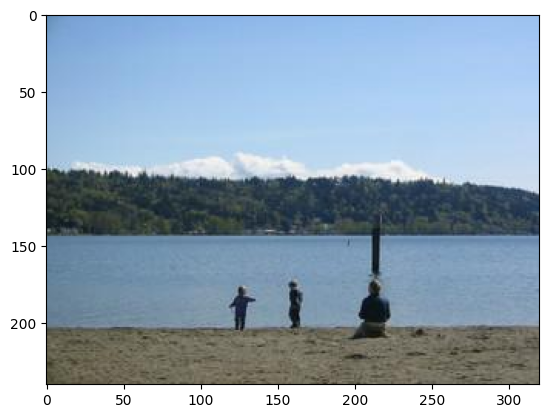

In [6]:
image, mask = get_images_from_id(1, df)
plt.imshow(image)

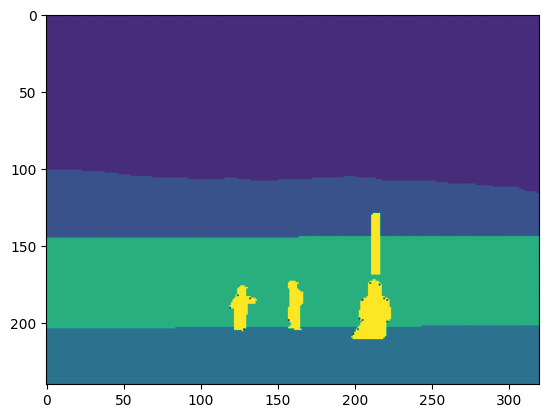

In [7]:
plt.imshow(mask)

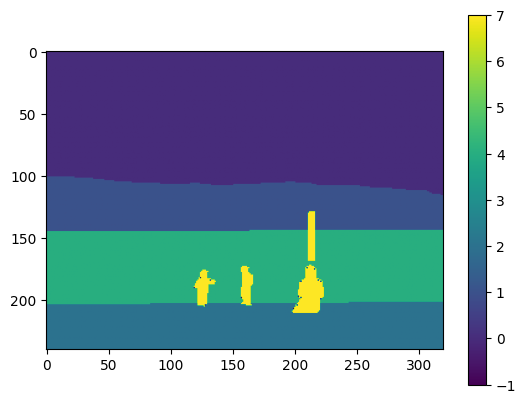

In [8]:
plt.imshow(mask)
plt.colorbar()

## mask encoding and decoding functions 

In [9]:
# this function transform the mask in the one hot encoded version

def one_hot_encode(mask):
    out = np.zeros(shape=(*mask.shape, 9))

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i,j]>=0:
                out[i, j, int(mask[i,j])] = 1
            else:
                out[i,j, 8] = 1

    return out



In [10]:
# this function transform the one hot encoded version on the mask in a plottable one
def one_hot_decode(mask):

    out = np.zeros(shape=mask.shape[:-1])

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            out[i][j] = mask[i, j, :].argmax()
            if out[i][j] == 8:
                out[i][j] = -1

    return out

## Testing functions

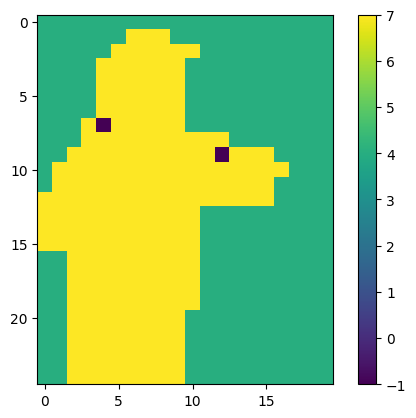

In [11]:
mask_testing = mask[175:200, 120:140]
plt.imshow(mask_testing)
plt.colorbar()
output_test = one_hot_encode(mask_testing)

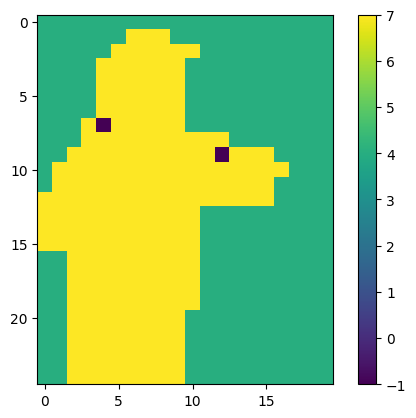

In [12]:
plt.imshow(one_hot_decode(output_test))
plt.colorbar()

## examples

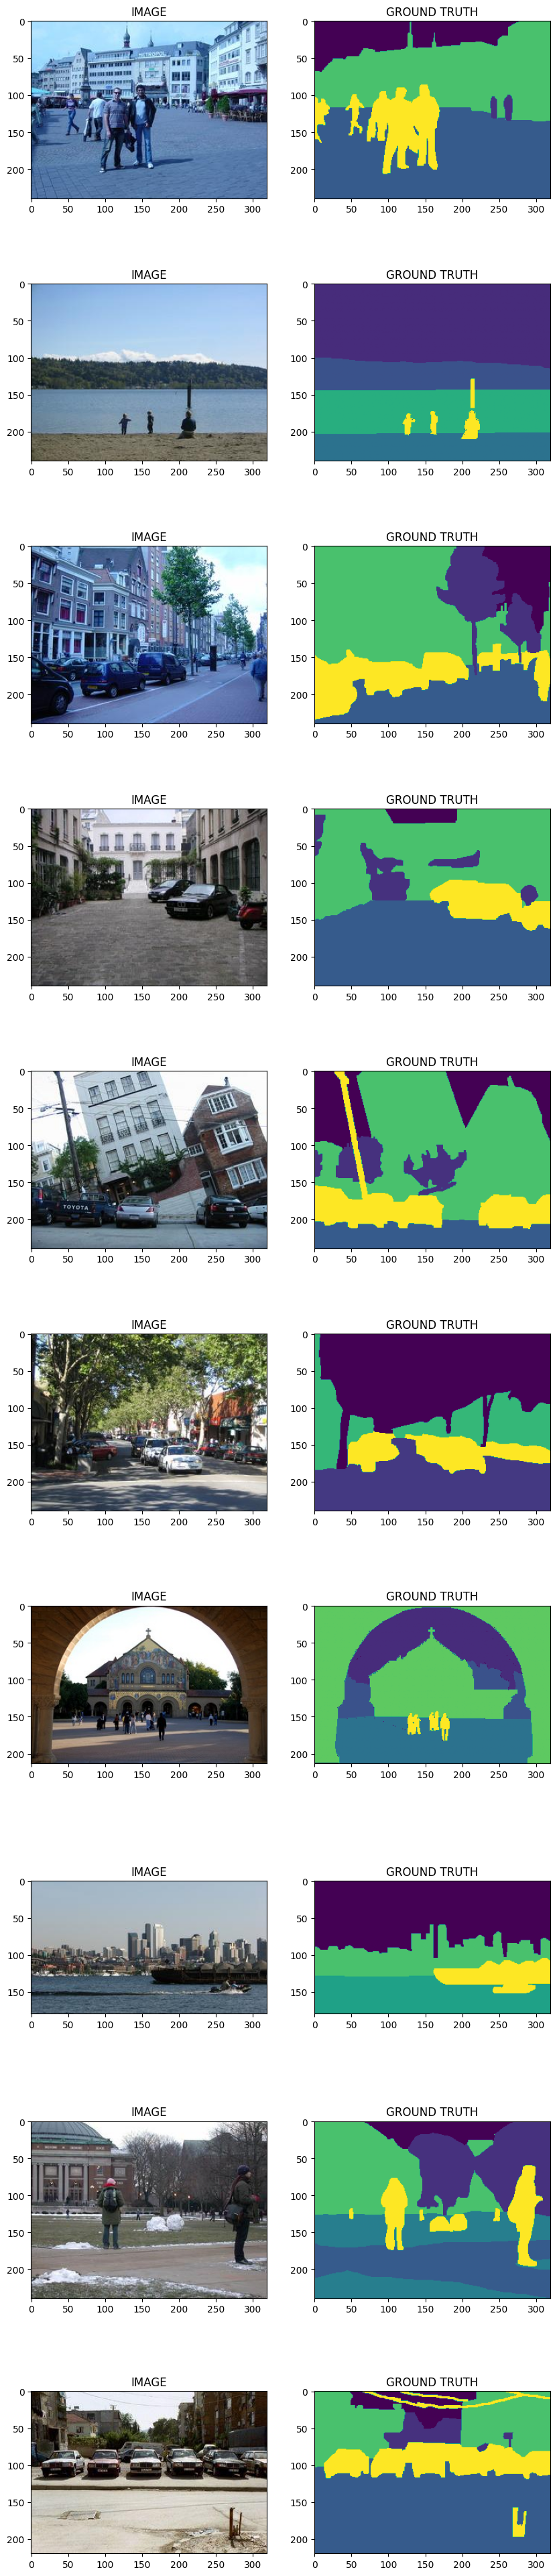

In [91]:
N_IMM_TO_PLOT = 10

f, ax = plt.subplots(N_IMM_TO_PLOT, 2, figsize=(10,N_IMM_TO_PLOT*5))

for i in range(N_IMM_TO_PLOT):    
    image, mask = get_images_from_id(i) 
    ax[i][0].set_title('IMAGE')
    ax[i][0].imshow(image)

    ax[i][1].set_title('GROUND TRUTH')
    ax[i][1].imshow(mask)

## test train split

In [92]:
train_df, test_df = train_test_split(df, test_size=.2)

train_df, valid_df = train_test_split(train_df, test_size=.2)

In [93]:
print(f'train_df size: {train_df.shape}')
print(f'valid_df size: {valid_df.shape}')
print(f'test_df size: {test_df.shape}')

train_df size: (457, 4)
valid_df size: (115, 4)
test_df size: (143, 4)


# Augmentation

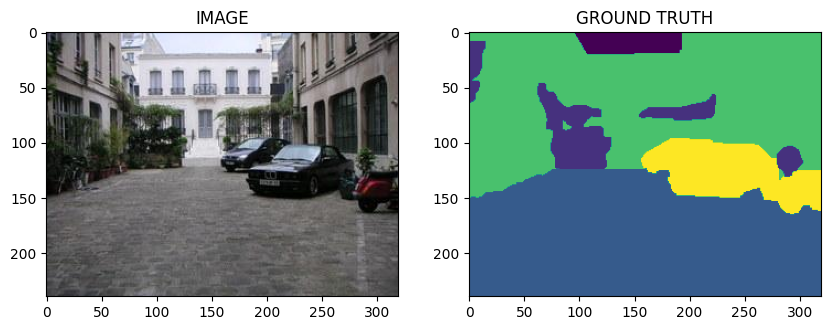

In [94]:
# testing augmentation

f, ax = plt.subplots(1, 2, figsize=(10,1*5))

image, mask = get_images_from_id(3) 
ax[0].set_title('IMAGE')
ax[0].imshow(image)

ax[1].set_title('GROUND TRUTH')
ax[1].imshow(mask)

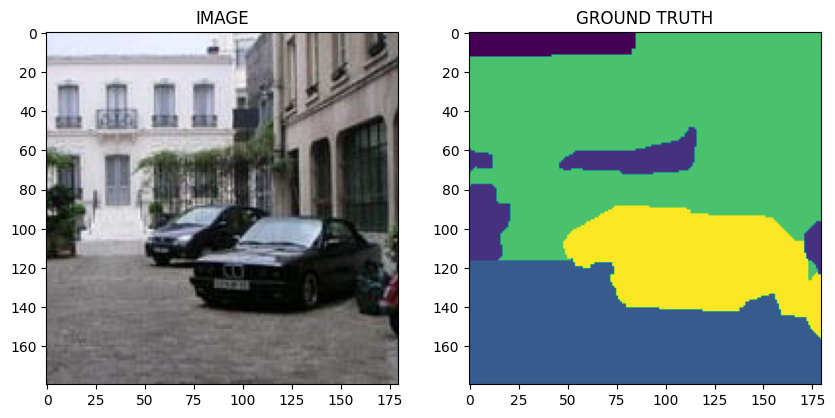

In [95]:
data = A.Compose([A.augmentations.crops.transforms.RandomCrop (180, 180, always_apply=False, p=1.0)])(image=image, mask=mask)

aug_image = data['image'] #(h,w,c)
aug_mask = data['mask'] #(h,w,c)


f, ax = plt.subplots(1, 2, figsize=(10,1*5))

ax[0].set_title('IMAGE')
ax[0].imshow(aug_image)

ax[1].set_title('GROUND TRUTH')
ax[1].imshow(aug_mask)

In [113]:
def train_aug():
    return A.Compose([        
        A.HorizontalFlip(p=0.5),
        A.augmentations.geometric.rotate.Rotate(limit=[-30,30]),
        A.augmentations.crops.transforms.RandomCrop (min_height, min_witdh, always_apply=False, p=0.1),
        A.Resize(HEIGHT, WITDH),        
    ])

def valid_aug():
        return A.Compose([
        A.Resize(HEIGHT, WITDH)
    ])

# Custom Dataset 

In [114]:
class SegmentationDataset(Dataset):

    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):

        image, mask = get_images_from_id(idx, self.df) #h,w,c
        mask = one_hot_encode(mask)
        
        if self.augmentations:
            data = self.augmentations(image = image, mask = mask)
            image = data['image'] #(h,w,c)
            mask = data['mask'] #(h,w,c)

        # allining with pytorch convention
        image = np.transpose(image, (2,0,1)).astype(np.float32) # (c, h ,w)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32) # (c, h ,w)

        image = torch.Tensor(image) / 255.0
        mask = torch.Tensor(mask)
        return image, mask

In [115]:
trainset = SegmentationDataset(train_df, train_aug())
validset = SegmentationDataset(valid_df, valid_aug())
testset = SegmentationDataset(test_df, valid_aug())

In [116]:
print(f'size train: {len(trainset)}')
print(f'size valid: {len(validset)}')
print(f'size test: {len(testset)}')

size train: 457
size valid: 115
size test: 143


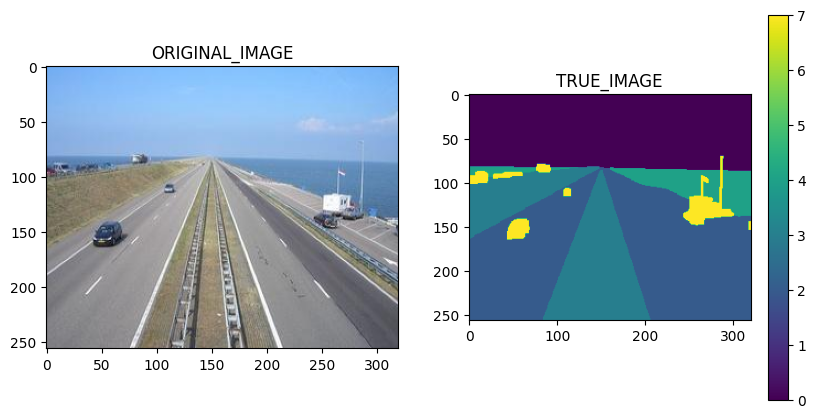

In [118]:
idx = 5

image, mask = validset[idx]

show_image(image, mask)

Batches creation

In [120]:
from torch.utils.data import DataLoader

trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size= BATCH_SIZE)
testloader = DataLoader(testset, batch_size= BATCH_SIZE)

In [121]:
print(f'train n batch = {len(trainloader)}')
print(f'test n batch = {len(testloader)}')
print(f'valid n batch = {len(validloader)}')

train n batch = 58
test n batch = 18
valid n batch = 15


In [122]:
for images, masks in trainloader:
    print(images.shape)
    print(masks.shape)
    break

#(dim_batch, channels, h , w)

torch.Size([8, 3, 256, 320])
torch.Size([8, 9, 256, 320])


# Segmentation Model

In [123]:
import segmentation_models_pytorch as smp

from torch import nn

In [124]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.backbone = smp.Unet(
            encoder_name = ENCODER,
            encoder_weights= WEIGTHS,
            in_channels = 3,
            classes = 9,
            activation = 'softmax',
         
        )

    def forward(self, images):
        logits = self.backbone(images)

        return logits

            

In [125]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16

# train and validation

In [126]:
def train_f( dataloader, model, optimizer, loss_f):
    model.train()

    total_loss = 0.0

    for images, masks in tqdm(dataloader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()

        logits = model(images)

        loss = loss_f(masks, logits)
    
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    return (total_loss/ len(dataloader))

In [127]:
def eval_f( dataloader, model, loss_f):
    model.eval()

    total_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits = model(images)

            loss = loss_f(masks, logits)

            total_loss += loss.item()

        return (total_loss/ len(dataloader))

# Train Model

In [128]:
opt = torch.optim.Adam(model.parameters(), lr = LR)

loss_f = nn.CrossEntropyLoss()


In [129]:
current_loss = np.inf

for i in range(EPOCHS):
    t_loss = train_f(trainloader, model, opt, loss_f)
    v_loss = eval_f(validloader, model, loss_f)

    if v_loss < current_loss:
        torch.save(model.state_dict(), "model.pytorch")
        print('MODEL_SAVED')
        current_loss = v_loss

    print(f'EPOCH: {i + 1}, Train loss: {t_loss}, valid loss: {v_loss}')

100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


MODEL_SAVED
EPOCH: 1, Train loss: 1.849427747315374, valid loss: 1.798589015007019


100%|██████████| 15/15 [00:05<00:00,  2.87it/s]


MODEL_SAVED
EPOCH: 2, Train loss: 1.7673021966013416, valid loss: 1.7962504784266153


100%|██████████| 15/15 [00:05<00:00,  2.77it/s]


MODEL_SAVED
EPOCH: 3, Train loss: 1.7645471075485493, valid loss: 1.7449432929356894


100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


EPOCH: 4, Train loss: 1.7508393854930484, valid loss: 1.7455855846405028


100%|██████████| 15/15 [00:05<00:00,  2.77it/s]


EPOCH: 5, Train loss: 1.7390397191047668, valid loss: 1.7901361068089803


100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


EPOCH: 6, Train loss: 1.7355917979931008, valid loss: 1.7482096672058105


100%|██████████| 15/15 [00:07<00:00,  2.01it/s]


MODEL_SAVED
EPOCH: 7, Train loss: 1.7270491102646137, valid loss: 1.7334802150726318


100%|██████████| 15/15 [00:07<00:00,  1.94it/s]


MODEL_SAVED
EPOCH: 8, Train loss: 1.7307927012443542, valid loss: 1.6745325009028116


100%|██████████| 15/15 [00:08<00:00,  1.86it/s]


MODEL_SAVED
EPOCH: 9, Train loss: 1.7151380777359009, valid loss: 1.6621112744013469


100%|██████████| 15/15 [00:07<00:00,  1.88it/s]


MODEL_SAVED
EPOCH: 10, Train loss: 1.7237539024188602, valid loss: 1.6583349307378132


100%|██████████| 15/15 [00:07<00:00,  1.96it/s]


EPOCH: 11, Train loss: 1.7028987695430886, valid loss: 1.688233749071757


100%|██████████| 15/15 [00:07<00:00,  1.92it/s]


EPOCH: 12, Train loss: 1.6971119190084523, valid loss: 1.6717015584309896


100%|██████████| 15/15 [00:07<00:00,  1.93it/s]


MODEL_SAVED
EPOCH: 13, Train loss: 1.6884913382859066, valid loss: 1.6530713399251302


100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


EPOCH: 14, Train loss: 1.6875436799279575, valid loss: 1.6710612932840982


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


EPOCH: 15, Train loss: 1.6962508394800384, valid loss: 1.6576728423436482


100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


EPOCH: 16, Train loss: 1.687377983126147, valid loss: 1.676293166478475


100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


EPOCH: 17, Train loss: 1.6939165222233739, valid loss: 1.6666810115178425


100%|██████████| 15/15 [00:05<00:00,  2.82it/s]


EPOCH: 18, Train loss: 1.6886239031265522, valid loss: 1.6679160356521607


100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


MODEL_SAVED
EPOCH: 19, Train loss: 1.6818935151757866, valid loss: 1.6431662718454996


100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


EPOCH: 20, Train loss: 1.6917429422510082, valid loss: 1.6455554167429607


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


EPOCH: 21, Train loss: 1.6801768479676082, valid loss: 1.6696168740590414


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


MODEL_SAVED
EPOCH: 22, Train loss: 1.6914666726671417, valid loss: 1.6409144401550293


100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


EPOCH: 23, Train loss: 1.6788288375426983, valid loss: 1.6486904939015707


100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


EPOCH: 24, Train loss: 1.6830796681601425, valid loss: 1.6565778096516928


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


MODEL_SAVED
EPOCH: 25, Train loss: 1.6828454938428155, valid loss: 1.6351502418518067


100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


MODEL_SAVED
EPOCH: 26, Train loss: 1.643344770217764, valid loss: 1.6137861013412476


100%|██████████| 15/15 [00:05<00:00,  2.77it/s]


MODEL_SAVED
EPOCH: 27, Train loss: 1.6320246601926869, valid loss: 1.5851608355840048


100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


EPOCH: 28, Train loss: 1.6338770389556885, valid loss: 1.5990295251210531


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


EPOCH: 29, Train loss: 1.633511352127996, valid loss: 1.6133109331130981


100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


EPOCH: 30, Train loss: 1.629502218345116, valid loss: 1.6079865535100302


100%|██████████| 15/15 [00:05<00:00,  2.84it/s]


EPOCH: 31, Train loss: 1.636695985136361, valid loss: 1.5984052419662476


100%|██████████| 15/15 [00:05<00:00,  2.81it/s]


EPOCH: 32, Train loss: 1.6152616081566646, valid loss: 1.589884066581726


100%|██████████| 15/15 [00:05<00:00,  2.84it/s]


EPOCH: 33, Train loss: 1.6234662882212936, valid loss: 1.5876800219217937


100%|██████████| 15/15 [00:05<00:00,  2.75it/s]


EPOCH: 34, Train loss: 1.6273017176266373, valid loss: 1.588786212603251


100%|██████████| 15/15 [00:05<00:00,  2.88it/s]


EPOCH: 35, Train loss: 1.6231981248691165, valid loss: 1.5889178037643432


100%|██████████| 15/15 [00:05<00:00,  2.83it/s]


EPOCH: 36, Train loss: 1.621156764441523, valid loss: 1.5911705414454143


100%|██████████| 15/15 [00:05<00:00,  2.88it/s]


EPOCH: 37, Train loss: 1.6157435815909813, valid loss: 1.587735692660014


100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


MODEL_SAVED
EPOCH: 38, Train loss: 1.6272646743675758, valid loss: 1.5796929200490315


100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


EPOCH: 39, Train loss: 1.6093079057233086, valid loss: 1.6193585793177288


100%|██████████| 15/15 [00:05<00:00,  2.76it/s]


MODEL_SAVED
EPOCH: 40, Train loss: 1.6052684537295638, valid loss: 1.5727582931518556


100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


EPOCH: 41, Train loss: 1.6143287666912736, valid loss: 1.5847757895787558


100%|██████████| 15/15 [00:05<00:00,  2.83it/s]


EPOCH: 42, Train loss: 1.6078350996148998, valid loss: 1.6044759670893352


100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


EPOCH: 43, Train loss: 1.613541685301682, valid loss: 1.5842925548553466


100%|██████████| 15/15 [00:05<00:00,  2.80it/s]


MODEL_SAVED
EPOCH: 44, Train loss: 1.6045374849746967, valid loss: 1.5703043619791666


100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


EPOCH: 45, Train loss: 1.6082985236726959, valid loss: 1.571183204650879


100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


EPOCH: 46, Train loss: 1.6019992335089321, valid loss: 1.5797276655832926


100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


EPOCH: 47, Train loss: 1.6063894876118363, valid loss: 1.5829356988271077


100%|██████████| 15/15 [00:08<00:00,  1.84it/s]


MODEL_SAVED
EPOCH: 48, Train loss: 1.5966143155920094, valid loss: 1.5604106585184734


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


EPOCH: 49, Train loss: 1.597508401706301, valid loss: 1.5615445454915364


100%|██████████| 15/15 [00:05<00:00,  2.85it/s]

EPOCH: 50, Train loss: 1.5905985215614582, valid loss: 1.5773046652475993


# some examples

In [145]:
def show_image(image, mask, pred = None):

    if pred == None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))        
        ax1.set_title('ORIGINAL_IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze())        
        ax2.set_title('TRUE_IMAGE')        
        im2 = ax2.imshow(one_hot_decode(mask.permute(1,2,0).squeeze()))
        plt.colorbar(im2,ax=ax2)

        return ax1, ax2, None
        
    elif pred != None :
        
        fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))        
        ax1.set_title('ORIGINAL_IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze())        
        ax2.set_title('TRUE_IMAGE')
        im2 = ax2.imshow(one_hot_decode(mask.permute(1,2,0).squeeze()))  

        cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
        fig.colorbar(im2, cax=cbar_ax)
    
        ax3.set_title('PRED_IMAGE')
        ax3.imshow(one_hot_decode(pred.permute(1,2,0).squeeze()))

        return ax1, ax2, ax3

In [146]:
idx = 15

model.load_state_dict(torch.load('model.pytorch'))

image, mask = testset[idx]

pred = model(image.to(DEVICE).reshape(1, *image.shape)) # the model needs a batch even if of just 1

pred.shape

torch.Size([1, 9, 256, 320])

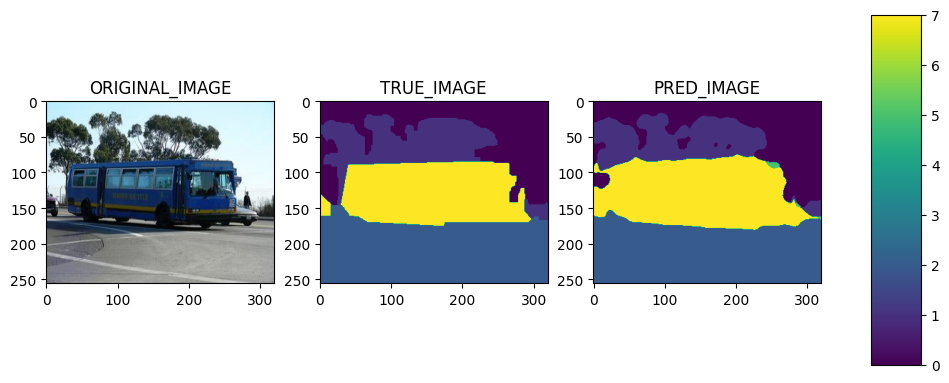

In [147]:
ax1, ax2, ax3 = show_image(image, mask, pred.detach().cpu().reshape(9, HEIGHT, WITDH))

In [151]:
pred.shape

torch.Size([1, 9, 256, 320])

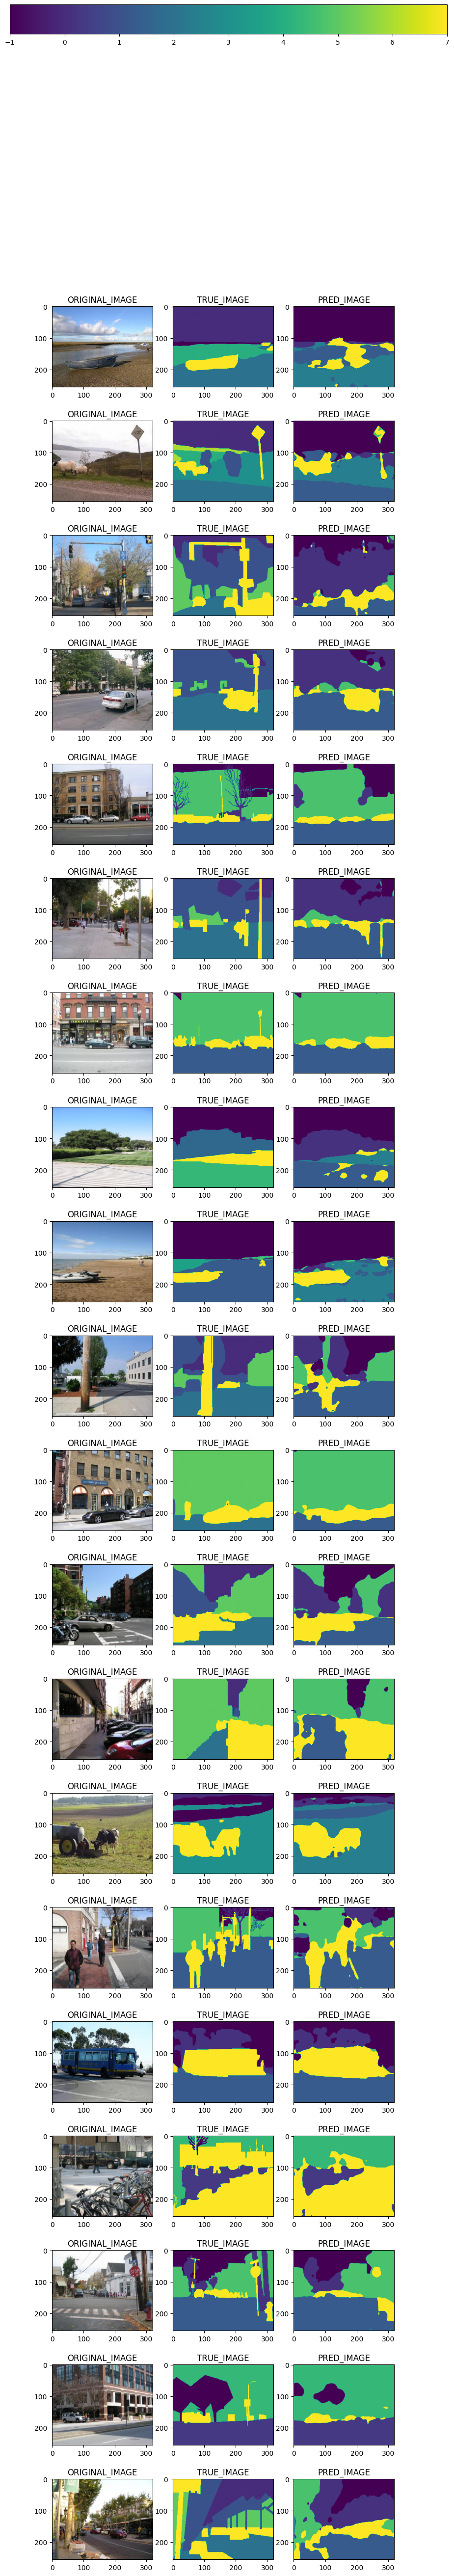

In [168]:
N_IMM_TO_PLOT = 20

f, ax = plt.subplots(N_IMM_TO_PLOT, 3, figsize=(9,N_IMM_TO_PLOT*3))
# f.tight_layout()

for i in range(N_IMM_TO_PLOT):    
      
    image, mask = testset[i]
    pred = model(image.to(DEVICE).reshape(1, *image.shape)) 

    ax[i][0].set_title('ORIGINAL_IMAGE')
    ax[i][0].imshow(image.permute(1,2,0).squeeze())        
    ax[i][1].set_title('TRUE_IMAGE')
    im2 = ax[i][1].imshow(one_hot_decode(mask.permute(1,2,0).squeeze()))  

    ax[i][2].set_title('PRED_IMAGE')
    ax[i][2].imshow(one_hot_decode(pred.squeeze().permute(1,2,0)))

cbar_ax = f.add_axes([0.03, 0.97, 0.99, 0.01])
f.colorbar(im2, cax=cbar_ax, orientation='horizontal')